## Importar

In [1]:
import numpy as np
import pandas as pd
import os 
import sys
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import GridSearchCV
import optuna
import optuna.visualization as vis
from catboost import CatBoostClassifier

from Classes.dataframe_manager import DataFrameManager

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold
import time
from sklearn.model_selection import RandomizedSearchCV
from sklearn import accuracy_score

c:\Users\LENOVO\anaconda3\envs\EnsamblesCatBoost\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Leer datos

In [2]:
# Asegurar que el directorio del proyecto esté en sys.path
project_root = os.getcwd()
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
# Carga de dataframes utilizando la clase DataFrameManager
manager = DataFrameManager()
manager.load_multiple([
    'features_upsampled',
    'features_valid',
    'features_upsampled_ord',
    'features_valid_ord',
    'target_upsampled',
    'target_valid',
    'target_upsampled_ord',
    'target_valid_ord'
])

DataFrame 'features_upsampled' cargado exitosamente en el administrador.
DataFrame 'features_valid' cargado exitosamente en el administrador.
DataFrame 'features_upsampled_ord' cargado exitosamente en el administrador.
DataFrame 'features_valid_ord' cargado exitosamente en el administrador.
DataFrame 'target_upsampled' cargado exitosamente en el administrador.
DataFrame 'target_valid' cargado exitosamente en el administrador.
DataFrame 'target_upsampled_ord' cargado exitosamente en el administrador.
DataFrame 'target_valid_ord' cargado exitosamente en el administrador.


In [4]:
# Asignar cada dataframe a una variable con su nombre para utilizarla en el notebook

features_upsampled = manager.get_dataframe('features_upsampled')
features_valid = manager.get_dataframe('features_valid')
features_upsampled_ord = manager.get_dataframe('features_upsampled_ord')
features_valid_ord = manager.get_dataframe('features_valid_ord')
target_upsampled = manager.get_dataframe('target_upsampled')
target_valid = manager.get_dataframe('target_valid')
target_upsampled_ord = manager.get_dataframe('target_upsampled_ord')
target_valid_ord = manager.get_dataframe('target_valid_ord')

## Creación de modelos

### Regresión logística

#### Busqueda en cuadrícula de hiperparámetros

In [5]:
# Definir los valores de cuadrícula de los hiperparámetros
dual = [True, False]
max_iter = [10000, 15000, 20000, 25000, 30000]
param_grid = dict(dual=dual, max_iter=max_iter)

In [6]:
# Crear modelo
model_lr = LogisticRegression(penalty='l2', 
                              solver='liblinear',
                              random_state=12345)

# Crear cuadrícula
grid = GridSearchCV(estimator=model_lr, 
                    param_grid=param_grid,
                    cv=5)

In [ ]:
# Convierte a 1D si era 2D
target_upsampled = target_upsampled.squeeze()

# Entrenar modelo
start_time = time.time()
grid_result = grid.fit(features_upsampled, target_upsampled)
probabilities_valid = grid_result.predict_proba(features_valid)[:, 1]
# probabilities_one_valid = probabilities_valid
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid)
auc_roc_lr_grid = roc_auc_score(target_valid, probabilities_valid)
print('El AUC-ROC score al usar la busqueda en cuadrícula y validación cruzada fue de :', auc_roc_lr_grid)
print('Tiempo de ejecución:' + str((time.time() - start_time)) + 'ms')

El AUC-ROC score al usar la busqueda en cuadrícula y validación cruzada fue de : 0.8614772727272728
Tiempo de ejecución:2.315129280090332ms


#### Busqueda aleatorio de hiperparámetros

In [ ]:
model_lr_random = RandomizedSearchCV(estimator=model_lr, param_distributions=param_grid, cv=5)
# Convierte a 1D si era 2D
target_upsampled = target_upsampled.squeeze()
# Entrenar modelo
start_time = time.time()
grid_result_rdm = grid.fit(features_upsampled, target_upsampled)
probabilities_valid_rdm = grid_result_rdm.predict_proba(features_valid)[:, 1]
# probabilities_one_valid_rdm = probabilities_valid_rdm
fpr_rdm, tpr_rdm, thresholds_rdm = roc_curve(
    target_valid, probabilities_valid_rdm)
auc_roc_lr_rdm = roc_auc_score(target_valid, probabilities_valid_rdm)
print('El AUC-ROC score al usar la busqueda en cuadrícula y validación cruzada fue de :', auc_roc_lr_rdm)
print('Tiempo de ejecución:' + str((time.time() - start_time)) + 'ms')

El AUC-ROC score al usar la busqueda en cuadrícula y validación cruzada fue de : 0.8614772727272728
Tiempo de ejecución:1.9473581314086914ms


#### Gráfico comparativo

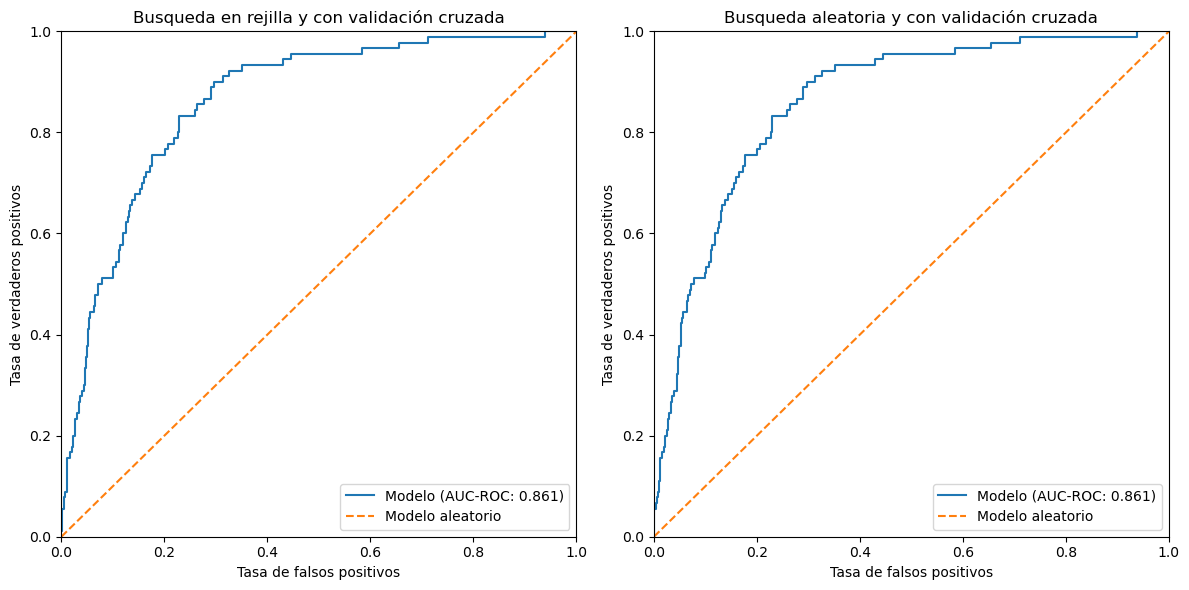

In [9]:
# Crear una figura con una fila y dos columnas
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico 1: Busqueda en rejilla
axes[0].plot(fpr, tpr,  
             label=f'Modelo (AUC-ROC: {auc_roc_lr_grid:.3f})')
axes[0].plot([0, 1], [0, 1], linestyle='--', label='Modelo aleatorio')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.0])
axes[0].set_xlabel('Tasa de falsos positivos')
axes[0].set_ylabel('Tasa de verdaderos positivos')
axes[0].set_title('Busqueda en rejilla y con validación cruzada')
axes[0].legend()

# Gráfico 2: Busqueda aleatoria
axes[1].plot(fpr_rdm, tpr_rdm, 
             label=f'Modelo (AUC-ROC: {auc_roc_lr_rdm:.3f})')
axes[1].plot([0, 1], [0, 1], linestyle='--', label='Modelo aleatorio')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.0])
axes[1].set_xlabel('Tasa de falsos positivos')
axes[1].set_ylabel('Tasa de verdaderos positivos')
axes[1].set_title('Busqueda aleatoria y con validación cruzada')
axes[1].legend()

# Ajustar espacio entre subgráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

El AUC-ROC es el mismo tanto en la busqueda en rejilla como en la aleatoria, sin embargo, la optimización de hiperparámetros de forma aleatoria permite llegar al mismo resultado 0.02 segundos antes.

### Bosque aleatorio de clasificación

#### Optimización de hiperparámetros

##### Sin validación cruzada

In [10]:
# Creación del modelo de Bosque Aleatorio simple
rfc = RandomForestClassifier(random_state=12345)
target_upsampled_ord = target_upsampled_ord.squeeze()  # Convertir de 2D a 1D

start_time = time.time()
rfc.fit(features_upsampled_ord, target_upsampled_ord)

# Obtener las probabilidades predichas para la clase positiva en el conjunto de entrenamiento
rfc_pred = rfc.predict(features_upsampled_ord)
rfc_probabilities_train = rfc.predict_proba(features_upsampled_ord)[:, 1]

# Calcular la curva ROC
fpr_rfc, tpr_rfc, thresholds = roc_curve(
    target_upsampled_ord, rfc_probabilities_train)

# Calcular el AUC-ROC y ACC
auc_score_rfc_train = roc_auc_score(target_upsampled_ord, rfc_probabilities_train)
acc_score_rfc_train = accuracy_score(target_upsampled_ord, rfc_pred)
print('El AUC-ROC score usando el conjunto de entrenamiento sin CV es:',
      auc_score_rfc_train)
print('El accuracy score usando el conjunto de entrenamiento sin CV es:',
      acc_score_rfc_train)
print('Tiempo de ejecución:' + str((time.time() - start_time)) + 'ms')

El AUC-ROC score usando Random Forest Classifier sin CV : 0.8865530303030305
Tiempo de ejecución:0.5555355548858643ms


In [ ]:
# Obtener las probabilidades predichas para la clase positiva en el conjunto de validación
rfc_pred_valid = rfc.predict(features_valid_ord)
rfc_probabilities_valid = rfc.predict_proba(features_valid_ord)[:, 1]

# Calcular la curva ROC
fpr_rfc, tpr_rfc, thresholds = roc_curve(
    target_valid_ord, rfc_probabilities_valid)

# Calcular el AUC-ROC
auc_score_rfc = roc_auc_score(target_valid_ord, rfc_probabilities_valid)
acc_score_rfc = accuracy_score(target_valid_ord, rfc_pred_valid)
print('El AUC-ROC score usando el conjunto de validación sin CV :', auc_score_rfc)
print('El accuracy score usando el conjunto de validación sin CV es:', acc_score_rfc)
print('Tiempo de ejecución:' + str((time.time() - start_time)) + 'ms')

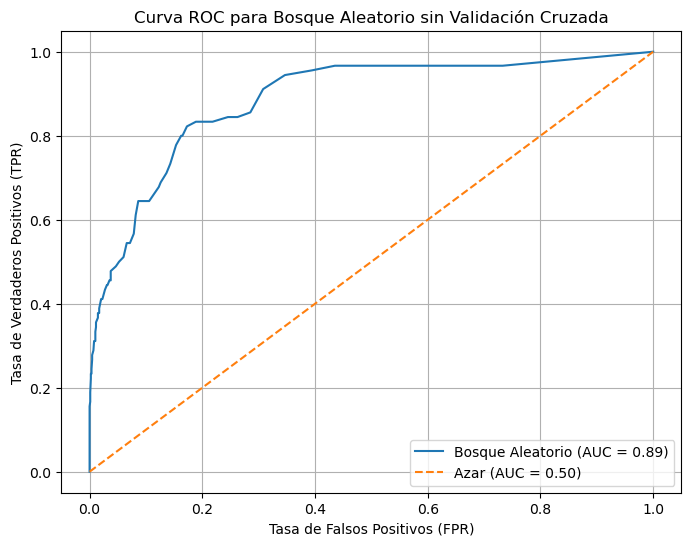

In [13]:
# # Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rfc, tpr_rfc, 
         label=f'Bosque Aleatorio (AUC = {auc_score_rfc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', 
         label='Azar (AUC = 0.50)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para Bosque Aleatorio sin CV en el conjunto de validación')
plt.legend(loc='lower right')
plt.grid()
plt.show()

##### Con validación cruzada

#### GridSearchCV

In [14]:
# Definir hiperparámetros a tunear
forest_params = [
    {'max_depth': list(range(1, 10)),
     'n_estimators': list(range(1, 50)),
     'min_samples_split': [2, 5, 10],
     'min_samples_leaf': [1, 2, 4]}
]

In [ ]:
# Configurar GridSearchCV con la métrica de evaluación AUC-ROC
clf = GridSearchCV(
    rfc,
    forest_params,
    cv=5,
    scoring={'roc_auc': 'roc_auc', 'accuracy': 'accuracy'}, 
    refit='roc_auc',
    error_score='raise'
    )

# Entrenar el modelo con GridSearchCV
start_time = time.time()
clf.fit(features_upsampled_ord, target_upsampled_ord)

# Obtener las probabilidades predichas para la clase positiva en el conjunto de entrenamiento
clf_probabilities_train = clf.predict_proba(features_upsampled_ord)[:, 1]
clf_pred = clf.predict(features_upsampled_ord)

# Calcular la curva ROC
fpr_clf, tpr_clf, thresholds = roc_curve(
    target_upsampled_ord, clf_probabilities_train)

# Calcular el AUC-ROC y accuracy
auc_score_clf_train = roc_auc_score(
    target_upsampled_ord, clf_probabilities_train)
acc_score_clf_train = accuracy_score(
    target_upsampled_ord, clf_pred)

print(f"Mejor valor para max_depth: {clf.best_params_['max_depth']}")
print(f"Mejor valor para n_estimators: {clf.best_params_['n_estimators']}")
print(f"Mejor estimador: {clf.best_estimator_}")
print(f"Mejor puntuación de AUC-ROC: {clf.best_score_}")
print(f"Mehor accuracy score: {acc_score_clf_train}")
print('Tiempo de ejecución:' + str((time.time() - start_time)) + 'ms')

Mejor valor para max_depth: 9
Mejor valor para n_estimators: 46
Mejor estimador: RandomForestClassifier(max_depth=9, n_estimators=46, random_state=12345)
Mejor puntuación: 0.9894462879039247


In [ ]:
# Creación de modelo con mejores hiperparámetros
clf = RandomForestClassifier(
    max_depth=9, 
    n_estimators=46, 
    random_state=12345
)

# Entrenamiento del modelo con los mejores hiperparámetros
start_time = time.time()
clf.fit(features_upsampled_ord, target_upsampled_ord)
probabilities_valid_clf = clf.predict_proba(features_valid_ord)[:,1]
pred_valid_clf = clf.predict(features_valid_ord)

# Calcular la curva ROC
fpr_clf, tpr_clf, thresholds = roc_curve(
    target_valid_ord, probabilities_valid_clf)

# Calcular el AUC-ROC y accuracy
auc_score_clf = roc_auc_score(target_valid_ord, probabilities_valid_clf)
acc_score_clf = accuracy_score(target_valid_ord, pred_valid_clf)

print('El AUC-ROC score  en el conjunto de valiadción  usando hiperparámetros optimizados :', auc_score_clf)
print('El accuracy score en el conjunto de validación usando hiperparámetros optimizados :', acc_score_clf)
print('Tiempo de ejecución:' + str((time.time() - start_time)) + 'ms')

El AUC-ROC score usando en conjunto de valiadción con usando hiperparámetros optimizados : 0.8865530303030305
Tiempo de ejecución:0.19071125984191895ms


#### Optuna

In [ ]:

class ModelOptimization:
    '''
    Creación de clase para tunear hiperparámetros utilizando Optuna
    '''

    def __init__(self, features_train, features_valid, target_train, target_valid):
        self.features_train = features_train
        self.features_valid = features_valid
        self.target_train = target_train
        self.target_valid = target_valid

    def objective(self, trial):
        # Definir los hiperparámetros a optimizar
        max_depth = trial.suggest_int('max_depth', 1, 10)
        n_estimators = trial.suggest_int('n_estimators', 1, 50)

        # Crear el modelo con los hiperparámetros sugeridos
        model = RandomForestClassifier(
            max_depth=max_depth, n_estimators=n_estimators, random_state=12345)

        # Entrenar el modelo
        model.fit(self.features_train, self.target_train)
        
        #Predecir probabilidades en el conjunto de entrenamiento
        pred_train_proba = model.predict_proba(
            self.features_train)[:, 1]
        pred_train = model.predict(self.features_train)

        # Predecir probabilidades en el conjunto de validación
        predictions_valid_proba = model.predict_proba(
            self.features_valid)[:, 1]
        pred_valid = model.predict(self.features_valid)

        # Calcular el AUC-ROC y accuracy
        auc_score = roc_auc_score(self.target_valid, predictions_valid_proba)
        acc_score = accuracy_score(self.target_valid, pred_valid)
        auc_score_train = roc_auc_score(self.target_train, pred_train_proba)
        acc_score_train = accuracy_score(self.target_train, pred_train)
        
        return auc_score, acc_score, auc_score_train, acc_score_train

In [ ]:
# Para ejecutar Optuna
def optimize_model(features_train, features_valid, target_train, target_valid, n_trials=50):
    optimizer = ModelOptimization(
        features_train, features_valid, target_train, target_valid)
    study = optuna.create_study(direction='maximize')  # Maximizar el AUC-ROC
    study.optimize(optimizer.objective, n_trials=n_trials)

    print(f"Mejores parámetros: {study.best_params}")
    print(f"Mejor AUC-ROC score en el conjunto de validación: {study.best_value['auc_score']:.4f}")
    print(f"Mejor accuracy score en el conjunto de validación: {study.best_value['acc_score']:.4f}")
    print(f"Mejor AUC-ROC score en el conjunto de entrenamiento: {study.best_value['auc_score_train']:.4f}")
    print(f"Mejor accuracy score en el conjunto de entrenamiento: {study.best_value['acc_score_train']:.4f}")

    return study

In [ ]:
# Ejecutar la optimización
study = optimize_model(features_upsampled_ord, features_valid_ord,
                       target_upsampled_ord, target_valid_ord, n_trials=2000)

In [ ]:
# Graficar el historial de optimización

vis.plot_optimization_history(study).show()

#### Potenciación de gradiente

In [ ]:
# Crear el modelo de CatBoost
model_cat = CatBoostClassifier(
    learning_rate=0.02,
    depth=7,
    random_seed=54321,
    iterations=2000,
    loss_function='Logloss',  # Pérdida adecuada para clasificación binaria
    eval_metric='AUC',        # Métrica de evaluación correcta
    verbose=100
)

In [ ]:
# Entrenar el modelo
model_cat.fit(features_upsampled_ord, target_upsampled_ord, cat_features=None)

# Obtener probabilidades sobre el conjunto de validación
preds_proba = model_cat.predict_proba(features_valid_ord)[:, 1]

# Calcular AUC-ROC
auc_score = roc_auc_score(target_valid_ord, preds_proba)
print(f"AUC-ROC Score: {auc_score:.4f}")

#### CatBoost y Optuna

In [ ]:
# Definir el número de iteraciones para early stopping
early_stopping_rounds = 50  # Número de iteraciones consecutivas sin mejora permitidas


def optuna_catboost(trial):
    # Definir los hiperparámetros que Optuna optimizará
    param = {
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.02, step=0.001),
        'depth': trial.suggest_int('depth', 7, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 5.5, step=0.5),
        'grow_policy': 'Depthwise',
        'iterations': 4000,
        'use_best_model': True,
        'eval_metric': 'AUC',
        'loss_function': 'Logloss',
        'od_type': 'Iter',
        'od_wait': early_stopping_rounds,
        'random_state': 54321,
        'logging_level': 'Silent'
    }

    # Inicializar el modelo de clasificación con los hiperparámetros definidos
    cat_classifier = CatBoostClassifier(**param)

    # Configurar la validación cruzada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=54321)

    auc_scores = []

# Iterar sobre cada fold de la validación cruzada
    for train_idx, valid_idx in cv.split(features_upsampled_ord, target_upsampled_ord):
        X_train, X_valid = features_upsampled_ord.iloc[train_idx], features_upsampled_ord.iloc[valid_idx]
        y_train, y_valid = target_upsampled_ord.iloc[train_idx], target_upsampled_ord.iloc[valid_idx]

        # Entrenar el modelo con early stopping
        cat_classifier.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            early_stopping_rounds=early_stopping_rounds,
            verbose=False  # Silenciar la salida durante el entrenamiento
        )

        # Predecir probabilidades en el conjunto de validación
        preds_proba = cat_classifier.predict_proba(X_valid)[:, 1]

        # Calcular el AUC-ROC para el fold actual
        auc = roc_auc_score(y_valid, preds_proba)
        auc_scores.append(auc)

    # Calcular el promedio del AUC-ROC a través de todos los folds
    mean_auc = np.mean(auc_scores)

    return mean_auc

In [ ]:
# Configurar y ejecutar el estudio de Optuna
study = optuna.create_study(
    direction='maximize', sampler=optuna.samplers.TPESampler(seed=12345))
# Puedes ajustar n_trials y timeout según tus necesidades
study.optimize(optuna_catboost, n_trials=100, timeout=600)

# Obtener los mejores hiperparámetros
best_params = study.best_params
best_auc = study.best_value

print(f"Mejores hiperparámetros: {best_params}")
print(f"Mejor AUC-ROC promedio: {best_auc:.4f}")